**Set Up**

In [1]:
!pip install -q pyspark

In [2]:
# to use mongoDB
# original intent was to add labels and sentiment score to mongoDB, but did not have opportunity to finish
!pip install pymongo[tls,srv]

In [3]:
# import packages

# pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import lower, col, monotonically_increasing_id, udf, regexp_replace
from pyspark.sql import functions as f
from pymongo import MongoClient

# etc
import timeit
import time
import os
import os.path
import json
import csv
import pandas as pd
import re
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

# text processing
#from nltk.stem import SnowballStemmer
#from nltk.stem.lancaster import LancasterStemmer
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist, word_tokenize
from nltk.tokenize import word_tokenize
wordnet_lemmatizer = WordNetLemmatizer()
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import wordnet as wn
from nltk.corpus import genesis
from nltk.wsd import lesk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('genesis')
genesis_ic = wn.ic(genesis, False, 0.0)

# topic modeling - DNU
import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet

# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

# classification algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

# clustering algorithm
from sklearn.cluster import DBSCAN

# pipeline
from sklearn.pipeline import Pipeline

# evaluation + validation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, ShuffleSplit
from sklearn import metrics

# visualizations
import matplotlib.pyplot as plt

# display max column width
pd.set_option('display.max_colwidth', -1)


#from sklearn.decomposition import NMF, LatentDirichletAllocation
#from sklearn import metrics
#from sklearn.decomposition import PCA
#from geopy.distance import great_circle

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Package genesis is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [4]:
# create spark context
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
# get IP for mongodb
!curl ipecho.net/plain

34.86.84.56

In [ ]:
# set up monogo connection to hwTest db
clientTest = MongoClient('not including due to pw')
db = clientTest.hwTest

# set up connection to collection
collection = db["project"]

# verify connection
serverStatusResult=db.command("serverStatus")
print(serverStatusResult)

{'host': 'cluster0-shard-00-02.qvahh.mongodb.net:27017', 'version': '4.4.10', 'process': 'mongod', 'pid': 244722, 'uptime': 3272992.0, 'uptimeMillis': 3272991659, 'uptimeEstimate': 3272991, 'localTime': datetime.datetime(2021, 11, 26, 14, 13, 42, 202000), 'asserts': {'regular': 0, 'warning': 0, 'msg': 0, 'user': 0, 'rollovers': 0}, 'connections': {'current': 7, 'available': 493, 'totalCreated': 188}, 'extra_info': {'note': 'fields vary by platform', 'page_faults': 0}, 'network': {'bytesIn': 86405880, 'bytesOut': 44760538, 'numRequests': 9549}, 'opcounters': {'insert': 101847, 'query': 311, 'update': 0, 'delete': 0, 'getmore': 2, 'command': 9209, 'deprecated': {'query': 0, 'getmore': 0}}, 'opcountersRepl': {'insert': 0, 'query': 0, 'update': 0, 'delete': 0, 'getmore': 0, 'command': 0, 'deprecated': {'query': 0, 'getmore': 0}}, 'repl': {'topologyVersion': {'processId': ObjectId('616efa76ac21ec466289c8f6'), 'counter': 6}, 'hosts': ['cluster0-shard-00-00.qvahh.mongodb.net:27017', 'cluster0

Code Used to Gather Tweets

In [ ]:
# http://adilmoujahid.com/posts/2014/07/twitter-analytics/

#from tweepy.streaming import StreamListener
#from tweepy import OAuthHandler
#from tweepy import Stream

#Variables that contains the user credentials to access Twitter API
#consumer_key = 
#consumer_secret = 
#access_token = 
#access_token_secret = 

#save_file = open('medstudenttwitter1009.v1.json', 'a')

#This is a basic listener that just prints received tweets to stdout.
#class StdOutListener(StreamListener):

#    def on_data(self, data):
#        if isinstance(data, dict):
#            # An attempt to cut down on non English tweets.
#            if data['user']['lang'] != 'en':
#                return


#        print(data)
#        save_file.write(str(data))
#        return True

#    def on_error(self, status):
#        print(status)

#if __name__ == '__main__':

    #This handles Twitter authetification and the connection to Twitter Streaming API
#    l = StdOutListener()
#    auth = OAuthHandler(consumer_key, consumer_secret)
#    auth.set_access_token(access_token, access_token_secret)

#while True:
#	try:
#		stream = Stream(auth, l)
#		stream.filter(track=['applicationfever', 'jbcarmody', 'eras','match2022','medtwitter','medstudents','aamc','match2021','medicalresidency','usmle', 'resident','residency'])
#	except: 
#		continue

**Obtain and Scrub**

Load data in pyspark dataframe and filter

In [ ]:
# Load Twitter data

# empty list
data = []

# append line by line from first file
for line in open('/content/medstudenttwitter1003.1.json'):
    try:
        data.append(json.loads(line))
    except:
        pass

# append line by line from second file
for line in open('/content/medstudenttwitter1003.2.json'):
    try:
        data.append(json.loads(line))
    except:
        pass

for line in open('/content/medstudenttwitter1004.1.json'):
    try:
        data.append(json.loads(line))
    except:
        pass
    
for line in open('/content/medstudenttwitter1004.2.json'):
    try:
        data.append(json.loads(line))
    except:
        pass
    
for line in open('/content/medstudenttwitter1005.v1.json'):
    try:
        data.append(json.loads(line))
    except:
        pass
    
for line in open('/content/medstudenttwitter1005.v2.json'):
    try:
        data.append(json.loads(line))
    except:
        pass
    
for line in open('/content/medstudenttwitter1006.v1.json'):
    try:
        data.append(json.loads(line))
    except:
        pass
    
for line in open('/content/medstudenttwitter1006.v2.json'):
    try:
        data.append(json.loads(line))
    except:
        pass

for line in open('/content/medstudenttwitter1007.v1.json'):
    try:
        data.append(json.loads(line))
    except:
        pass
    
for line in open('/content/medstudenttwitter1007.v2.json'):
    try:
        data.append(json.loads(line))
    except:
        pass
    
for line in open('/content/medstudenttwitter1008.v1.json'):
    try:
        data.append(json.loads(line))
    except:
        pass
    
for line in open('/content/medstudenttwitter1008.v2.json'):
    try:
        data.append(json.loads(line))
    except:
        pass

for line in open('/content/medstudenttwitter1008.v3.json'):
    try:
        data.append(json.loads(line))
    except:
        pass
    
for line in open('/content/medstudenttwitter1009.v1.json'):
    try:
        data.append(json.loads(line))
    except:
        pass
    
# check length
print(len(data))

158395


In [ ]:
# removing any error messages from Twitter API
tweets = []
for T in data:
    if 'text' in T:
        tweets.append(T)

# check length - no error messages        
len(tweets)

158395

In [ ]:
# def function to get extended tweet text if tweet is truncated
def tweetText(T):
    if T["truncated"]:
        return T['extended_tweet']['full_text']
    else:
        return T['text']

In [ ]:
# extract data from tweets
ids = [T['id_str'] for T in tweets] # twitter id
times = [T['created_at'] for T in tweets] # timestamp
texts = [tweetText(T) for T in tweets] # text
screen_names = [T['user']['screen_name'] for T in tweets] # user screen_name
followers_count = [T['user']['followers_count'] for T in tweets] # follower count
friends_count = [T['user']['friends_count'] for T in tweets] # friend count
names = [T['user']['name'] for T in tweets] # user name
lang = [T['lang'] for T in tweets] # language

# open csv for writing
out = open('tweetdata_out.csv', 'w', encoding='UTF-8', newline='')

# write header to csv
out.write('id,created_at,text,screen_name,followers_count,friends_count,name,lang\n')

# zip data
rows = list(zip(ids, times, texts, screen_names, followers_count, friends_count, names, lang))

# start to write to file
csv = csv.writer(out)

for row in rows:                       # for each row
    values = [value for value in row]
    csv.writerow(values)               # write data to csv

# close csv file
out.close()

In [ ]:
# get file
inputPath = os.path.join('/content/tweetdata_out.csv')
fileName = os.path.join(inputPath)
# read in file to pyspark dataframe
df0 = sqlContext.read.format('csv').option("multiLine","true").option('delimiter',',').option('header','true').load('/content/tweetdata_out.csv')

Preprocessing in PySpark

In [ ]:
# start timer for cleaning runtime
start_time = timeit.default_timer()

# filter out non-english tweets
df1 = df0.filter(df0.lang == 'en\r')
# convert text to lowercase
df1 = df1.withColumn('text', lower(col('text')))
# filter out retweets
df1 = df1.filter(~(df1.text.startswith('rt')))
# filter tweets that contain 'resident evil'
df2 = df1.filter(~(df1.text.contains('resident evil')))

# store id in twitter_id
df2 = df2.withColumn("twitter_id", df2["id"])
# store id used for mongoDB in _id
df_index = df2.select("*").withColumn("id", monotonically_increasing_id())
df_index=df_index.withColumnRenamed("id","_id")

# add columns for rigid filter
tags = ['applicationfever','jbcarmody','match2022','medtwitter','medstudents','aamc','match2021','usmle','medicalresidency','eras','resident','residency','student','doctor','match22','interview','applicant','program']
for i in tags:
  df_index = df_index.withColumn(i, df_index.text.contains(i).cast('integer'))

# add lesk algorithm definition of residency and resident
df_index = df_index.withColumn('resyDef',f.when(df_index.text.contains('residency'), lesk(word_tokenize(str(df_index.text)),'residency').definition()))
df_index = df_index.withColumn('resDef',f.when(df_index.text.contains('resident'), lesk(word_tokenize(str(df_index.text)),'resident').definition()))

# add boolean flag for existance of word physician in either definition
df_index = df_index.withColumn('resPhys',f.when(df_index.resyDef.contains('physician') | df_index.resDef.contains('physician'),1).otherwise(0))
# drop unneeded columns
df_index = df_index.drop('resyDef','resDef','lang')

# add filter column that sums tag columns
# lw_tags have a weight of 1
# hw_tags have a weight of 2
lw_tags = ['applicationfever','jbcarmody','medtwitter','medstudents','aamc','usmle','resPhys','eras',
           'student','doctor','interview','applicant','program']
hw_tags = ['match2022','match22','match2021','medicalresidency']
df_index = df_index.withColumn('filter', sum(df_index[col] for col in lw_tags)+sum(2*df_index[col] for col in hw_tags))

# produce elapsed time
elapsed = timeit.default_timer() - start_time
print(elapsed)

0.6776665780000712


In [ ]:
# convert to dictionary to load to database
toLoad = list(map(lambda row: row.asDict(), df_index.collect()))

# add to database
collection.insert_many(toLoad)

In [ ]:
# 22,763 out of 158,395 tweets remain
print(df2.count())

22763


Additional Tweet Cleaning in Pandas

In [ ]:
# convert to pandas for text cleaning
df_pd = df_index.toPandas()

In [ ]:
# text_cleaning function
def text_cleaning(dftext):
    # replace numbers with empty character
    dftext = dftext.replace('[0-9]', '')
    # replace strings that begin with http or www. with empty character
    dftext = dftext.replace('http\S+|www.\S+', '')
    # remove puntuation
    dftext = re.sub(r'[^\w\s]','',dftext)
    # replace string with non-alphabetic words & characters with space
    dftext = dftext.replace('[^a-zA-Z]', ' ')
    # replace words that are less than 3 characters long with space
    dftext = ' '.join(word for word in dftext.split() if len(word) > 3)
    # remove stopwords + extras
    more_stopwords = set(('cant', 'aint', 'today','tonight','today','something','said','really','que','must','take','make',
                         'together','begin','also','back','soon','get'))
    stoplist = stopwords.words('english')
    more_sw = set(stoplist) | more_stopwords
    dftext = ' '.join([word for word in dftext.split() if word not in (more_sw)])
    # update with lemmatized words
    dftext = ' '.join(wordnet_lemmatizer.lemmatize(word) for word in word_tokenize(dftext))
    # replace string with non-alphabetic words & characters with space
    dftext = dftext.replace('[^a-zA-Z]', ' ')
    return dftext

# function to remove mentions or links
def rem_mentions_sites(dftext):
    dftext = re.sub(r'(?:\@|https?\://)\S+','',dftext)
    return dftext

In [ ]:
# start timer for cleaning runtime
start_time2 = timeit.default_timer()

# remove mentions/links and clean tweet text
# store in clnNoMent
df_pd['clnNoMent'] = df_pd['text'].apply(rem_mentions_sites)
df_pd['clnNoMent'] = df_pd['clnNoMent'].apply(text_cleaning)

# produce elapsed time
end_time2 = timeit.default_timer()
elapsed2 = end_time2 - start_time2
print(elapsed2)

# rename filter column to avoid confusion with filter function
df_pd.rename(columns={'filter': 'filt'}, inplace=True)

# save to csv
df_pd.to_csv('tweetdata_cleaned.csv', index=False)

# retrieve csv
df_pd = pd.read_csv('/content/tweetdata_cleaned.csv')

9.484416876000068


**Explore**

In [ ]:
# function to display percentage
def perc(num):
  return ("{:.0%}".format(num))

In [ ]:
# total tag counts in unfiltered data
l1 = []
for i in tags:
  k = df_pd[i].sum()
  l1.append(k)
  print(i+' '+str(k))

applicationfever 0
jbcarmody 66
match2022 426
medtwitter 2420
medstudents 47
aamc 45
match2021 15
usmle 117
medicalresidency 0
eras 1979
resident 10199
residency 2831
student 523
doctor 507
match22 33
interview 293
applicant 127
program 483


In [ ]:
# percentage of total tag counts in unfiltered data
l2 = []
siz = len(df_pd.index)
for i in tags:
  k = round(df_pd[i].sum()/siz,2)
  l2.append(k)
  print(i+' '+perc(k))

applicationfever 0%
jbcarmody 0%
match2022 2%
medtwitter 11%
medstudents 0%
aamc 0%
match2021 0%
usmle 1%
medicalresidency 0%
eras 9%
resident 45%
residency 12%
student 2%
doctor 2%
match22 0%
interview 1%
applicant 1%
program 2%


In [ ]:
# total tag counts in rigid filter
l3 = []
for i in tags:
  k = df_pd[df_pd.filt>1][i].sum()
  l3.append(k)
  print(i+' '+str(k))

applicationfever 0
jbcarmody 17
match2022 426
medtwitter 530
medstudents 47
aamc 14
match2021 15
usmle 40
medicalresidency 0
eras 150
resident 127
residency 525
student 371
doctor 257
match22 33
interview 226
applicant 114
program 371


In [ ]:
# percentage of tag counts in rigid filter
l4 = []
siz = len(df_pd[df_pd.filt>1].index)
for i in tags:
  k = round(df_pd[df_pd.filt>1][i].sum()/siz,2)
  l4.append(k)
  print(i+' '+perc(k))

applicationfever 0%
jbcarmody 1%
match2022 31%
medtwitter 39%
medstudents 3%
aamc 1%
match2021 1%
usmle 3%
medicalresidency 0%
eras 11%
resident 9%
residency 38%
student 27%
doctor 19%
match22 2%
interview 16%
applicant 8%
program 27%


In [ ]:
# quick summary of changes seen in tag volume from unfiltered to rigidly filtered data
quick_sum = pd.DataFrame({'unfiltCount': l1,'unfiltPerc': l2,'filtCount': l3,'filtPerc': l4})
quick_sum.index = tags
quick_sum

,unfiltCount,unfiltPerc,filtCount,filtPerc
applicationfever,0,0.00,0,0.00
jbcarmody,66,0.00,17,0.01
match2022,426,0.02,426,0.31
medtwitter,2420,0.11,530,0.39
medstudents,47,0.00,47,0.03
aamc,45,0.00,14,0.01
match2021,15,0.00,15,0.01
usmle,117,0.01,40,0.03
medicalresidency,0,0.00,0,0.00
eras,1979,0.09,150,0.11


The visuazliation below shows desired changes in tag percentage from unfiltered to rigidgly filtere data. The "residency" tag decreased from 45% to 9%, which was exactly the intent of the rigid filter.

Text(0, 0.5, 'Percent of Tweets')

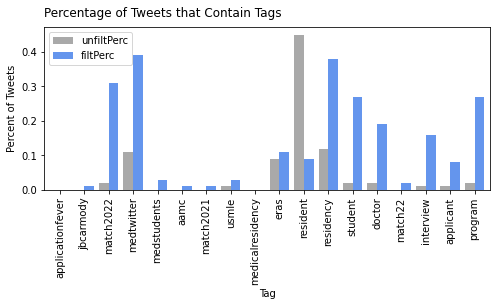

In [ ]:
# Visalize change in percentage of tags in unfiltered data to rigidly filtered data
quick_sum.plot(y=['unfiltPerc', 'filtPerc'], kind='bar', color=['darkgrey','cornflowerblue'], width=.8, figsize=(8,3)).legend(loc='upper left')
plt.title('Percentage of Tweets that Contain Tags', horizontalalignment='left',x=0, pad=10)
plt.xlabel('Tag')
plt.ylabel('Percent of Tweets')

In [ ]:
# text processing

# get_clean_tokens function
# takes a dataframe column
# returns cleaned tokens for regular or bigram freq distribution
# removes more words than original clean function

def get_clean_tokens(dfcol, bigramFlag=0):
    review = []
    for x in dfcol:
        review.append([x])
    
    tokens = str(review)   # convert list to str
    tokens = tokens.lower()   # convert all to lowercase
    tokens = re.sub("[^a-zA-Z0-9]", " ", tokens)   # remove characters that are not a-z, A-Z, or 0-9
    tokens = word_tokenize(tokens)   # tokenize
    
    if (bigramFlag == 0):   # if bigramFlag == 0
        wordnet_lemmatizer = WordNetLemmatizer()
        tokens = (wordnet_lemmatizer.lemmatize(word) for word in tokens)   # lemmatize tokens
    
    from nltk.corpus import stopwords  # pulling this import out of the function creates an error
    # set additional stopwords
    more_stopwords = set(('the','get','like','see','also','one','two','yesterday','want','day','http'))
    extra_stoplist = set(stopwords.words('english')) | more_stopwords   # create full stopword list in extra_stoplist
    tokens = (word for word in tokens if word not in extra_stoplist)   # remove all words from extra_stoplist
    tokens = (word for word in tokens if word.isalpha())   # remove words with characters that are not in the alphabet
    tokens = (word for word in tokens if len(word) >= 3)   # remove words less than 3 characters long
    return tokens   # return cleaned tokens

In [ ]:
# fdist function
# takes cleaned tokens and
# a bigramFlag with default = 0
# returns frequency distribution

def fdist(tokens, bigramFlag=0):
    if (bigramFlag != 0):   # if bigram flag is not 0
        tokens = nltk.bigrams(tokens)   # then create bigrams
    return nltk.FreqDist(tokens)   # return FreqDist on tokens

In [ ]:
# fdistdf function
# takes a frequency distribution, fdist
# returns dataframe with words in 1st column and frequency in 2nd column

def fdistdf(fdist):
    freq_word = []   # create empty list

    for k, v in list(fdist.items()):   # for each word, freq pair in fdist
        freq_word.append([k, v])       # add to empty list

    wordlist = pd.DataFrame(freq_word) # transform list to dataframe

    # rename first column to 'word' and second column to 'freq'
    wordlist = wordlist.rename(columns={0: 'word', 1: 'freq'})
    
    # return list sorted in descending frequency with indexes reset
    return wordlist.sort_values(by=['freq'], ascending=False).reset_index(drop=True)

**Word frequencies of tweets that contain match2022**

Tweets that metion match2022 are most likely in the set of tweets referring to the medical residency placement process. The word frequency distribution graphed below shows certain words such as interview, program, and applicant are seen frequently in these tweets. As such, interview, program, and applicant were added to the words included in the rigid filter.

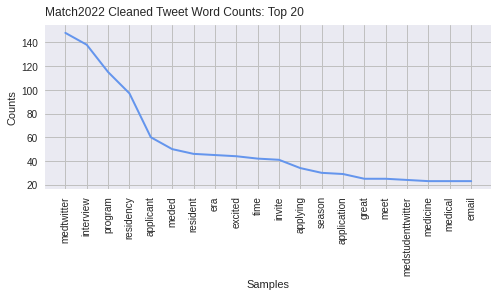

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(8,3))
plt.title('Match2022 Cleaned Tweet Word Counts: Top 20', horizontalalignment='left',x=0, pad=10)
fdist(get_clean_tokens(df_pd[df_pd.match2022==1]['clnNoMent'])).plot(20,color='cornflowerblue')

**Word frequencies of unfiltered tweets**

Looking at the unfiltered tweets, resident and residency are the most frequently seen followed by medtwitter. Era is also common as it is the stemmed result of eras, which was in the original list of words used to gather tweets.

In [ ]:
type(fdist(get_clean_tokens(df_pd['clnNoMent'])))
pd.DataFrame(list(fdist(get_clean_tokens(df_pd['clnNoMent'])).items()), columns = ["Word","Frequency"]).sort_values(by=['Frequency'], ascending=False).head(10)

,Word,Frequency
1,resident,10243
186,residency,2862
174,medtwitter,2410
22,era,1929
35,year,1241
98,time,1013
17,people,944
112,dont,879
830,medical,876
15,need,816


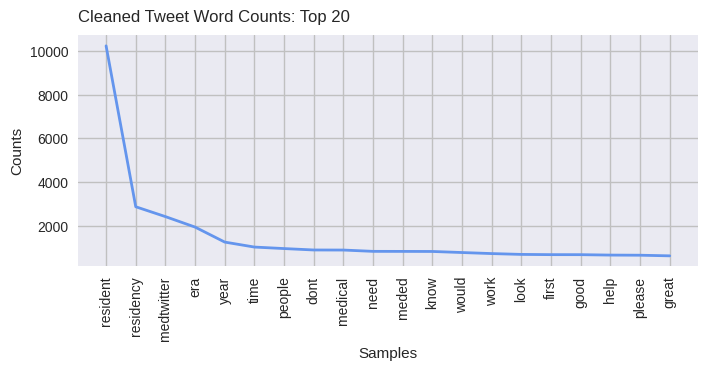

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(8,3))
plt.title('Cleaned Tweet Word Counts: Top 20', horizontalalignment='left',x=0, pad=10)
fdist(get_clean_tokens(df_pd['clnNoMent'])).plot(20,color='cornflowerblue')

**Bigram frequencies of unfiltered tweets**

We begin to see a lean in the data towards medical tweets when using bigrams.

The bigram “vega residency” is a result from the tweets speculating Adele’s Las Vegas residency.  The IELTS exam is an exam for those who wish to work or study in a country where the primary language is English. This bigram is likely a result from tweets discussing exams required for residency in another country. The “reisdent biden” bigram frequency comes from tweets by insurrectionists referring to President Biden.

The events below occured/were discussed during the time period tweets were collected.

1.  The trailer for the new Resident Evil film came out on October 7.
2.  An actor on The Resident discussed her departure from the show with Deadline on October 5.
3.  In the first week of October, it was rumored that Adele was considering locations for a Las Vegas residency.

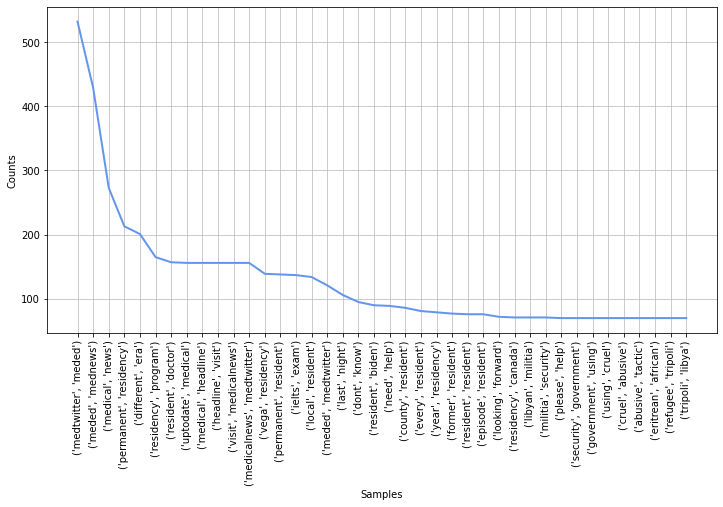

In [ ]:
# display top 40
plt.figure(figsize=(12,6))
fdist(get_clean_tokens(df_pd['clnNoMent']),1).plot(40,color='cornflowerblue')

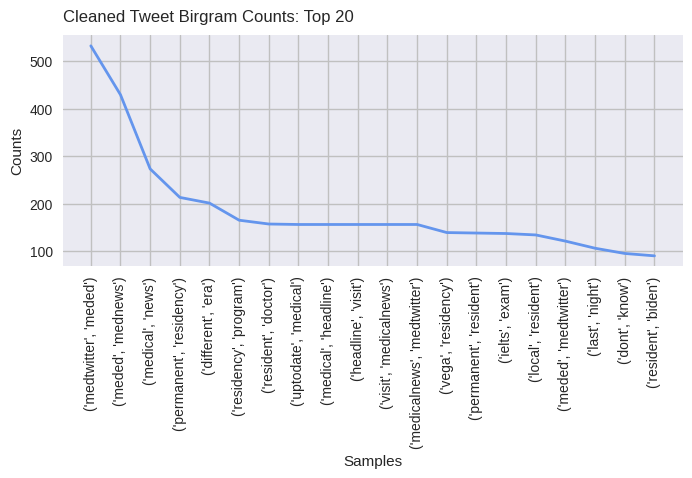

In [ ]:
# display top 20 and format for paper
plt.style.use('seaborn')
plt.figure(figsize=(8,3))
plt.title('Cleaned Tweet Birgram Counts: Top 20', horizontalalignment='left',x=0, pad=10)
fdist(get_clean_tokens(df_pd['clnNoMent']),1).plot(20,color='cornflowerblue')

**Word frequencies of rigidly filtered tweets**

The word frequencies of rigidly filtered tweets continue to show data appears as expected.

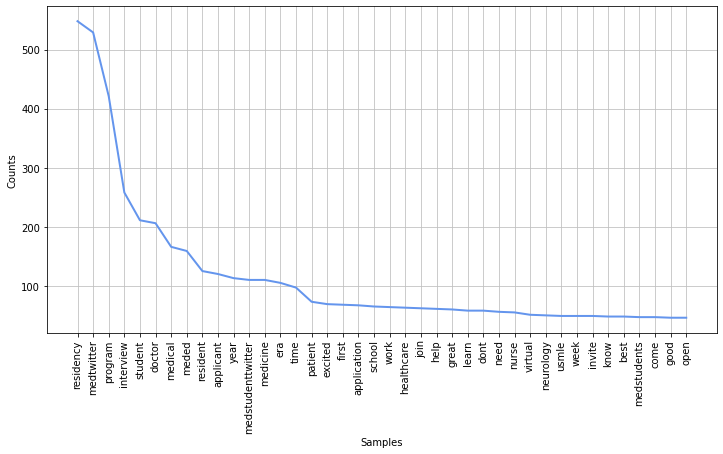

In [ ]:
plt.figure(figsize=(12,6))
fdist(get_clean_tokens(df_pd[df_pd.filt>1]['clnNoMent'])).plot(40,color='cornflowerblue')

**Bigram frequencies of rigidly filtered tweets**

The bigrams mentioned above ("vega residency", "IELTS exam", and "resident biden") are not present in the top 40 bigrams of the rigidly filtered data

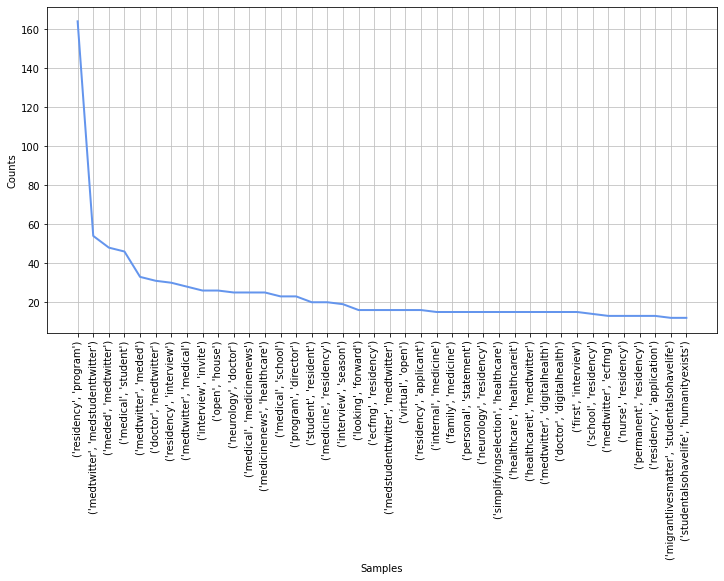

In [ ]:
plt.figure(figsize=(12,6))
fdist(get_clean_tokens(df_pd[df_pd.filt>1]['clnNoMent']),1).plot(40,color='cornflowerblue')

Add Manually Produced Labels For Modeling

In [ ]:
# get labels from csv
df_labels = pd.read_csv('/content/labels.csv')
df_labels.head(3)

,_id,label
0,15350,1.0
1,18779,1.0
2,15935,1.0


In [ ]:
# join with dataframe
df_pd = df_pd.join(df_labels.set_index('_id'), on='_id')
df_pd = 

Prepare For Modeling

In [ ]:
# Take sample of data as not enough RAM to process distance matrix of full dataset
df_samp = df_pd.sample(frac=.5)
# remove columns
toRemove = ['created_at','text','screen_name','followers_count','friends_count','name','twitter_id']
df_samp = df_samp.drop(toRemove, axis=1)
# save as csv
df_samp.to_csv('samp3_3.csv', index=False)

In [5]:
# retrieve csv
# provided samp3.csv file was used to compile results below
df_samp3 = pd.read_csv('/content/samp3_3.csv')
# remove null data from clnNoMent column
df_samp = df_samp3[df_samp3['clnNoMent'].notna()]

In [6]:
# create dataframe for classification
df_class = df_samp.dropna()
# create dataframe for clustering
df_clus = df_samp[df_samp.filt > 1]

Metric Evaluation/Printing Functions

In [7]:
# function to display 2 decimals of float
def two_d(num):
  return ("{:.2f}".format(num))

# function to print precision, recall, fpr, and f1 score
def print_eval(fp, fn, tp, tn):
  precision = tp / (tp + fp)
  print('Precision: '+two_d(precision))
  recall = tp / (tp + fn)
  print('Recall: '+two_d(recall))
  fprr = fp / (fp + tn)
  print('False Positive Rate: '+two_d(fprr))
  f1 = 2*((precision * recall) / (precision + recall))
  print('F1: '+two_d(f1)) 

# second function to print precision, recall, f1, and accuracy
def eval_metrics(p_labels,t_labels):
  pre = precision_score(p_labels,t_labels)
  rec = recall_score(p_labels,t_labels)
  f1 = f1_score(p_labels,t_labels)
  acc = accuracy_score(p_labels,t_labels)
  return pre, rec, f1, acc

# for repeated printing
def eval_metrics_print(pr, re, fone, ac):
  print('Precision: '+two_d(pr))
  print('Recall: '+two_d(re))
  print('F1: '+two_d(fone))
  print('Accuracy: '+two_d(ac))

**Rigid Filter**

Rigid Filter Evaluation

In [8]:
# compile dataframe for rows with label
dfRigidFilt = spark.createDataFrame(df_samp).na.drop()

In [9]:
# get labels and predictions
labels = dfRigidFilt.select('label').rdd.flatMap(lambda x: x).collect()
preds = [1 if x > 1 else 0 for x in dfRigidFilt.select('filt').rdd.flatMap(lambda x: x).collect()]

In [10]:
# metrics
rftpre, rftrec, rftf1, rftacc = eval_metrics(labels, preds)
eval_metrics_print(rftpre, rftrec, rftf1, rftacc)

Precision: 0.63
Recall: 0.74
F1: 0.68
Accuracy: 0.93


Rigid Filter Evaluation on Remaining Dataset

In [11]:
# compile dataframe
dfRigidFiltFull = spark.createDataFrame(df_samp)

In [12]:
# get labels and predictions
labelsF = dfRigidFiltFull.select('match2022').rdd.flatMap(lambda x: x).collect()
predsF = [1 if x > 1 else 0 for x in dfRigidFiltFull.select("filt").rdd.flatMap(lambda x: x).collect()]

In [13]:
# metrics
rftpr, rftre, rftf, rftac = eval_metrics(labelsF, predsF)
eval_metrics_print(rftpre, rftrec, rftf1, rftacc)

Precision: 0.63
Recall: 0.74
F1: 0.68
Accuracy: 0.93


**DBSCAN Clustering**

DBS Modeling

In [14]:
# create features
tfidf_vectorizer = TfidfVectorizer(decode_error ='ignore', stop_words='english', min_df=20, ngram_range=(1,1))
# fit+transform data and create array
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clus['clnNoMent']).toarray()
# find the cosine distance between documents
distance_array = pairwise_distances(tfidf_matrix, metric='cosine')
# cluster with epsilon = 0.5 and minimum samples = 50
clustering = DBSCAN(eps=.5, min_samples=50, metric='precomputed').fit(distance_array)
# create labels
df_clus['labelDBSCAN'] = clustering.labels_
df_clus['labelDBSCANConv'] = np.minimum(1,df_clus['labelDBSCAN']+1)

DBS Evaluation

In [15]:
# metrics
dbspre, dbsrec, dbsf1, dbsacc = eval_metrics(df_clus[(df_clus.label == 0) | (df_clus.label == 1)]['label'], 
                                             df_clus[(df_clus.label == 0) | (df_clus.label == 1)]['labelDBSCANConv'])
eval_metrics_print(dbspre, dbsrec, dbsf1, dbsacc)

Precision: 0.71
Recall: 0.74
F1: 0.73
Accuracy: 0.65


DBSCAN Evaluation on Remaining Dataset

In [16]:
# create df of rigidly filtered data
df_DBSamp = df_samp[df_samp.filt>1]

In [17]:
# fit+transform data and create array
tfidf_matrixN = tfidf_vectorizer.fit_transform(df_DBSamp['clnNoMent']).toarray()
# find the cosine distance between documents
distance_arrayN = pairwise_distances(tfidf_matrixN, metric='cosine')
# cluster with epsilon = 0.5 and minimum samples = 50
clusteringN = DBSCAN(eps=.5, min_samples=50, metric='precomputed').fit(distance_array)
# create labels
df_DBSamp['labelDBSCAN'] = clusteringN.labels_
df_DBSamp['labelDBSCANConv'] = np.minimum(1,df_DBSamp['labelDBSCAN']+1)

In [18]:
# metrics
dbspr, dbsre, dbsf, dbsac = eval_metrics(df_DBSamp['match2022'], df_DBSamp['labelDBSCANConv'])
eval_metrics_print(dbspr, dbsre, dbsf, dbsac)

Precision: 0.33
Recall: 0.72
F1: 0.45
Accuracy: 0.45


**Classification**

70/30 Split

In [19]:
# create 70/30 data split using df['clnNoMent'] and df['label']
# random state 2 because 2 is the best integer
x_train, x_test, y_train, y_test = train_test_split(df_class['clnNoMent'], df_class['label'], test_size=0.3, random_state=2)

**KNN Classification**

Modeling/Pipeline

In [20]:
# create pipline
# I left many of the arguments in to adjust while fine tuning all models
# Slightly surprisingly, the min_df=1 and ngram_range(1,1) produced the best results in the classification algorithms
knn_pipeline = Pipeline([('tfidf', TfidfVectorizer(decode_error ='ignore',min_df=1,ngram_range=(1,1))), ('clf', KNeighborsClassifier())])

# run data through pipeline
knn_pipeline = knn_pipeline.fit(x_train, y_train)

# get test labels
predicted_knn = knn_pipeline.predict(x_test)

KNN Evaluation

In [21]:
# metrics
knnpre, knnrec, knnf1, knnacc = eval_metrics(y_test, predicted_knn)
eval_metrics_print(knnpre, knnrec, knnf1, knnacc)

# AUC ROC
knn_prob = knn_pipeline.predict_proba(x_test)
knn_roc_auc_score = roc_auc_score(y_test, knn_prob[:,1])
print('AUC ROC: '+two_d(knn_roc_auc_score))

Precision: 0.82
Recall: 0.56
F1: 0.67
Accuracy: 0.95
AUC ROC: 0.86


KNN Cross Eval

In [22]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=2)
knn_rec_scores = cross_val_score(knn_pipeline,df_class['clnNoMent'], df_class['label'],cv=cv,  scoring='recall')
print(knn_rec_scores)
print('Avg KNN Recall Cross Val: '+two_d(np.mean(knn_rec_scores)))
knn_prec_scores = cross_val_score(knn_pipeline,df_class['clnNoMent'], df_class['label'],cv=cv,  scoring='precision')
print(knn_prec_scores)
print('Avg KNN Precision Cross Val: '+two_d(np.mean(knn_prec_scores)))
knn_f1_scores = cross_val_score(knn_pipeline,df_class['clnNoMent'], df_class['label'],cv=cv,  scoring='f1')
print(knn_f1_scores)
print('Avg KNN F1 Cross Val: '+two_d(np.mean(knn_f1_scores)))

[0.5625     0.35714286 0.31578947 0.3        0.24137931 0.42857143
 0.35294118 0.2962963  0.38888889 0.15789474]
Avg KNN Recall Cross Val: 0.34
[0.81818182 0.55555556 0.75       0.6        0.875      0.75
 0.66666667 1.         0.875      0.6       ]
Avg KNN Precision Cross Val: 0.75
[0.66666667 0.43478261 0.44444444 0.4        0.37837838 0.54545455
 0.46153846 0.45714286 0.53846154 0.25      ]
Avg KNN F1 Cross Val: 0.46


In [23]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
knn_cv_preds = cross_val_predict(knn_pipeline,df_class['clnNoMent'], df_class['label'],cv=10,  method='predict_proba')
print(two_d(np.mean(knn_cv_preds[:,0])))
print(two_d(np.mean(knn_cv_preds[:,1])))

0.88
0.12


KNN Evaluation on Remaining Dataset

In [24]:
# compile labels and probs for df_samp
all_knn_labels = knn_pipeline.predict(df_samp['clnNoMent'])
all_knn_prob = knn_pipeline.predict_proba(df_samp['clnNoMent'])
df_samp['knn_labels'] = all_knn_labels
df_samp['knn_prob'] = all_knn_prob[:,1]
knn_labels = df_samp['knn_labels']
knn_prob = df_samp['knn_prob']

In [25]:
# metrics
knnpr, knnre, knnf, knnac = eval_metrics(df_samp['match2022'], knn_labels)
eval_metrics_print(knnpr, knnre, knnf, knnac)

# AUC ROC
knn_roc_auc_scor = roc_auc_score(df_samp['match2022'], df_samp['knn_prob'])
print('AUC ROC: '+two_d(knn_roc_auc_scor))

Precision: 0.38
Recall: 0.61
F1: 0.46
Accuracy: 0.97
AUC ROC: 0.93


**SVM Classification**

SVM Model/Pipeline

In [26]:
# create pipeline
svm_pipeline = Pipeline([('tfidf', TfidfVectorizer(decode_error ='ignore',stop_words='english',ngram_range=(1,1))), ('cls', SVC(kernel='linear', probability=True))])

# run data through pipeline
svm_pipeline = svm_pipeline.fit(x_train, y_train)

# get test labels
predicted_svm = svm_pipeline.predict(x_test)

SVM Evaluation

In [27]:
# metrics
svmpre, svmrec, svmf1, svmacc = eval_metrics(y_test, predicted_svm)
eval_metrics_print(svmpre, svmrec, svmf1, svmacc)

# AUC ROC
svm_prob = svm_pipeline.predict_proba(x_test)
svm_roc_auc_score = roc_auc_score(y_test, svm_prob[:,1])
print('AUC ROC: '+two_d(svm_roc_auc_score))

Precision: 1.00
Recall: 0.50
F1: 0.67
Accuracy: 0.95
AUC ROC: 0.96


SVM Cross Eval

In [28]:
from sklearn.model_selection import ShuffleSplit
svm_rec_scores = cross_val_score(svm_pipeline,df_class['clnNoMent'], df_class['label'],cv=cv,  scoring='recall')
print(svm_rec_scores)
print('SVM Recall Cross Val: '+two_d(np.mean(svm_rec_scores)))
svm_prec_scores = cross_val_score(svm_pipeline,df_class['clnNoMent'], df_class['label'],cv=cv,  scoring='precision')
print(svm_prec_scores)
print('SVM Precision Cross Val: '+two_d(np.mean(svm_prec_scores)))
svm_f1_scores = cross_val_score(svm_pipeline,df_class['clnNoMent'], df_class['label'],cv=cv,  scoring='f1')
print(svm_f1_scores)
print('SVM F1 Cross Val: '+two_d(np.mean(svm_f1_scores)))

[0.5        0.35714286 0.47368421 0.6        0.4137931  0.42857143
 0.41176471 0.44444444 0.44444444 0.36842105]
SVM Recall Cross Val: 0.44
[1.         0.83333333 1.         0.92307692 0.92307692 1.
 1.         1.         1.         1.        ]
SVM Precision Cross Val: 0.97
[0.66666667 0.5        0.64285714 0.72727273 0.57142857 0.6
 0.58333333 0.61538462 0.61538462 0.53846154]
SVM F1 Cross Val: 0.61


In [29]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
svm_cv_preds = cross_val_predict(svm_pipeline,df_class['clnNoMent'], df_class['label'],cv=10,  method='predict_proba')
print(two_d(np.mean(svm_cv_preds[:,0])))
print(two_d(np.mean(svm_cv_preds[:,1])))

0.88
0.12


SVM Evaluation on Remaining Dataset

In [30]:
# compile labels and probs for df_samp
all_svm_labels = svm_pipeline.predict(df_samp['clnNoMent'])
all_svm_prob = svm_pipeline.predict_proba(df_samp['clnNoMent'])
df_samp['svm_labels'] = all_svm_labels
df_samp['svm_prob'] = all_svm_prob[:,1]
svm_labels = df_samp['svm_labels']
svm_prob = df_samp['svm_prob']

In [31]:
# metrics
svmpr, svmre, svmf, svmac = eval_metrics(df_samp['match2022'], svm_labels)
eval_metrics_print(svmpr, svmre, svmf, svmac)

# AUC ROC
svm_roc_auc_scor = roc_auc_score(df_samp['match2022'], df_samp['svm_prob'])
print('AUC ROC: '+two_d(svm_roc_auc_scor))

Precision: 0.79
Recall: 0.86
F1: 0.83
Accuracy: 0.99
AUC ROC: 0.99


**Additional Modeling Completed in ProjectSupplementary.ipynb**

**Logistic Regression Classification**

Done in other provided notebook for pyspark envinronment

In [32]:
lrgpre = 0.6667
lrgrec = 0.2857
lrgf1 = 0.4000
lrgacc = 0.9259
lrg_roc_auc_score = 0.8359

**PySpark SVM Classification**

I cannot find any information as to why the results are so poor compared to other SVM model. I believe the tf function is different in both environments.

In [33]:
svm2pre = 0.8571
svm2rec = 0.4286
svm2f1 = 0.5714
svm2acc = 0.9444

In [34]:
svm2pr = 0.4329
svm2re = 0.5837
svm2f = 0.4971
svm2ac = 0.9771

In [35]:
# read in PySp SVM results to dataframe
pySVM = sqlContext.read.format('csv').option('delimiter',',').option('header','true').load('/content/PySpSVMResults.csv')

**Model Comparison**

In [ ]:
from pyspark.sql.functions import avg, round

# Compile comparison of evaluation metrics
rigid_comp = {'Precision':[rftpre],'Recall':[rftrec],'Accuracy':[rftacc],'F1':[rftf1], 'AUC ROC': ['N/A']}
rigid_comp_df  = pd.DataFrame(data=rigid_comp,index=['Rigid Filter (RFT)'])
rigid_comp_psdf=spark.createDataFrame(rigid_comp_df)
rigid_comp_psdf.select([round((v), 3).alias(v) for v in rigid_comp_psdf.columns]).show()
rigid_comp_df.round(3)

+---------+------+--------+-----+-------+
|Precision|Recall|Accuracy|   F1|AUC ROC|
+---------+------+--------+-----+-------+
|    0.632| 0.741|   0.929|0.683|   null|
+---------+------+--------+-----+-------+



,Precision,Recall,Accuracy,F1,AUC ROC
Rigid Filter (RFT),0.632,0.741,0.929,0.683,N/A


In [41]:
unsupervised_comp = {'Precision':[dbspre],'Recall':[dbsrec],'Accuracy':[dbsacc],'F1':[dbsf1], 'AUC ROC': [np.nan]}
unsupervised_comp_df  = pd.DataFrame(data=unsupervised_comp,index=['DBSCAN (DBS)'])
unsupervised_comp_psdf=spark.createDataFrame(unsupervised_comp_df)
unsupervised_comp_psdf.show() #select([round((v), 3).alias(v) for v in unsupervised_comp_psdf.columns]).show() - started creating errors. unsure why.
unsupervised_comp_df.round(3)

+------------------+------------------+------------------+------------------+-------+
|         Precision|            Recall|          Accuracy|                F1|AUC ROC|
+------------------+------------------+------------------+------------------+-------+
|0.7111111111111111|0.7441860465116279|0.6470588235294118|0.7272727272727273|    NaN|
+------------------+------------------+------------------+------------------+-------+



,Precision,Recall,Accuracy,F1,AUC ROC
DBSCAN (DBS),0.711,0.744,0.647,0.727,NaN


In [58]:
supervised_comp = {'Precision':[knnpre,svmpre,lrgpre,svm2pre],'Recall':[knnrec,svmrec,lrgrec,svm2rec],'Accuracy':[knnacc,svmacc,lrgacc,svm2acc],'F1':[knnf1,svmf1,lrgf1,svm2f1],'AUC ROC': [knn_roc_auc_score,svm_roc_auc_score,lrg_roc_auc_score,np.nan]}
supervised_comp_df  = pd.DataFrame(data=supervised_comp,index=['K Nearest Neighbors (KNN)','Support Vector Machine (SVM)','Logistic Regression (LRG)','Logistic Regression (LRG)'])
supervised_comp_psdf=spark.createDataFrame(supervised_comp_df)
supervised_comp_df.round(3)

,Precision,Recall,Accuracy,F1,AUC ROC
K Nearest Neighbors (KNN),0.818,0.562,0.947,0.667,0.858
Support Vector Machine (SVM),1.000,0.500,0.953,0.667,0.956
Logistic Regression (LRG),0.667,0.286,0.926,0.400,0.836
Logistic Regression (LRG),0.857,0.429,0.944,0.571,NaN


In [ ]:
# Compile comparison of evaluation metrics for full dataset
rigid = {'Precision':[rftpr],'Recall':[rftre],'Accuracy':[rftac],'F1':[rftf], 'AUC ROC': ['N/A']}
rigid_df  = pd.DataFrame(data=rigid,index=['RFT'])
rigid_psdf=spark.createDataFrame(rigid_df)
rigid_psdf.select([round((v), 3).alias(v) for v in rigid_psdf.columns]).show(5)
rigid_df.round(3)

+---------+------+--------+-----+-------+
|Precision|Recall|Accuracy|   F1|AUC ROC|
+---------+------+--------+-----+-------+
|    0.317|   1.0|   0.958|0.481|   null|
+---------+------+--------+-----+-------+



,Precision,Recall,Accuracy,F1,AUC ROC
RFT,0.317,1.0,0.958,0.481,N/A


In [ ]:
unsupervised = {'Precision':[dbspr],'Recall':[dbsre],'Accuracy':[dbsac],'F1':[dbsf], 'AUC ROC': ['N/A']}
unsupervised_df  = pd.DataFrame(data=unsupervised,index=['DBSCAN (DBS)'])
unsupervised_psdf=spark.createDataFrame(unsupervised_df)
unsupervised_psdf.select([round((v), 3).alias(v) for v in unsupervised_psdf.columns]).show(5)
unsupervised_df.round(3)

+---------+------+--------+-----+-------+
|Precision|Recall|Accuracy|   F1|AUC ROC|
+---------+------+--------+-----+-------+
|    0.333| 0.719|   0.453|0.455|   null|
+---------+------+--------+-----+-------+



,Precision,Recall,Accuracy,F1,AUC ROC
DBSCAN (DBS),0.333,0.719,0.453,0.455,N/A


In [60]:
# Compile comparison of evaluation metrics
supervised = {'Precision':[knnpr,svmpr,svm2pr],'Recall':[knnre,svmre,svm2re],'Accuracy':[knnac,svmac,svm2ac],'F1':[knnf,svmf,svm2f],'AUC ROC': [knn_roc_auc_score,svm_roc_auc_scor,np.nan]}
supervised_df  = pd.DataFrame(data=supervised,index=['KNN','SVM','PSVM'])
supervised_psdf=spark.createDataFrame(supervised_df)
supervised_df.round(3)

,Precision,Recall,Accuracy,F1,AUC ROC
KNN,0.376,0.606,0.973,0.464,0.858
SVM,0.789,0.864,0.993,0.825,0.990
PSVM,0.433,0.584,0.977,0.497,NaN


In [42]:
from pyspark.sql.functions import row_number
from pyspark.sql import Window

# create sparkDF from list
def quickDF(values,c_name):
  return(sqlContext.createDataFrame([(i,) for i in values], [c_name]))

# join two sparkDFs
def quickDFJoin(df1,df2):
  df1 = df1.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
  df2 = df2.withColumn("row_idx", row_number().over(Window.orderBy(monotonically_increasing_id())))
  return(df1.join(df2, df1.row_idx == df2.row_idx).drop("row_idx"))

In [43]:
# combine all results in single dataframe
comb = quickDFJoin(dfRigidFiltFull,quickDF(predsF,'rft'))
comb = quickDFJoin(comb,quickDF(knn_labels,'knn'))
comb = quickDFJoin(comb,quickDF(knn_prob,'knn_prob'))
comb = quickDFJoin(comb,quickDF(svm_labels,'svm'))
comb = quickDFJoin(comb,quickDF(svm_prob,'svm_prob'))
comb = quickDFJoin(comb,quickDF(pySVM.select('prediction').rdd.flatMap(lambda x: x).collect(),'psvm'))

In [44]:
# get fpr, tpr, and auc_scores for KNN and SVM
fpr1, tpr1, thresh1 = roc_curve(labelsF, knn_prob, pos_label=1)
auc_score1 = roc_auc_score(labelsF, knn_prob)
fpr2, tpr2, thresh2 = roc_curve(labelsF, svm_prob, pos_label=1)
auc_score2 = roc_auc_score(labelsF, svm_prob)

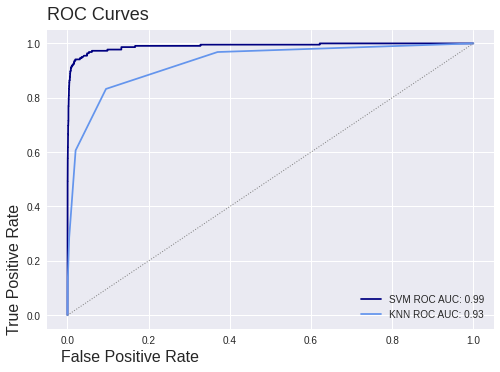

In [45]:
# Print AUC ROC
plt.style.use('seaborn')

plt.plot(fpr2, tpr2, color='navy', label='SVM ROC AUC: '+two_d(auc_score2))
plt.plot(fpr1, tpr1, color='cornflowerblue', label='KNN ROC AUC: '+two_d(auc_score1))
plt.plot([0, 1], [0, 1], color="grey", lw=1, linestyle=":")
plt.title('ROC Curves', fontsize=18, horizontalalignment='left',x=0, pad=10)
plt.xlabel('False Positive Rate', fontsize=16,horizontalalignment='left', x=0.03)
plt.ylabel('True Positive Rate', fontsize=16,verticalalignment = 'bottom', y=0.2)

plt.legend(loc='lower right')
plt.show()

**Sentiment Analysis**

In [46]:
# for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType
from pyspark.sql.types import *

# sent function returns vader sentiment score
def sent(clnText):
  return float(analyzer.polarity_scores(clnText)['compound'])

# udf needed to apply sent function to cleaned tweet text
udfSent = udf(sent, FloatType())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [47]:
# add sentiment to combined df
comb = comb.withColumn('sentiment', udfSent('clnNoMent'))

In [48]:
# get average sentiment for graph
unfilt_sent = comb.agg({"sentiment": "avg"}).collect()[0]["avg(sentiment)"]
filt_sent = comb.filter(comb['rft'] == 1).agg({"sentiment": "avg"}).collect()[0]["avg(sentiment)"]
svm_sent = comb.filter(comb['svm'] == 1).agg({"sentiment": "avg"}).collect()[0]["avg(sentiment)"]
svm2_sent = comb.filter(comb['psvm'] == 1).agg({"sentiment": "avg"}).collect()[0]["avg(sentiment)"]

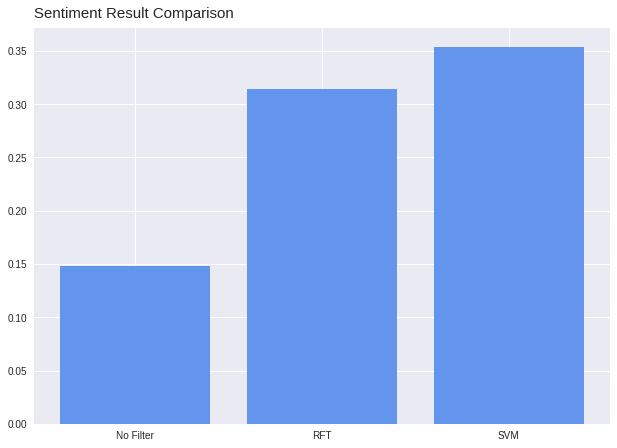

In [49]:
# Create sentiment comparison graph
import matplotlib.pyplot as plt
plt.style.use('seaborn')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
filters = ['No Filter', 'RFT', 'SVM']
value_v = [unfilt_sent,filt_sent,svm_sent]
ax.bar(filters,value_v,color='cornflowerblue')
plt.title('Sentiment Result Comparison', fontsize=15, horizontalalignment='left',x=0, pad=10)
plt.show()

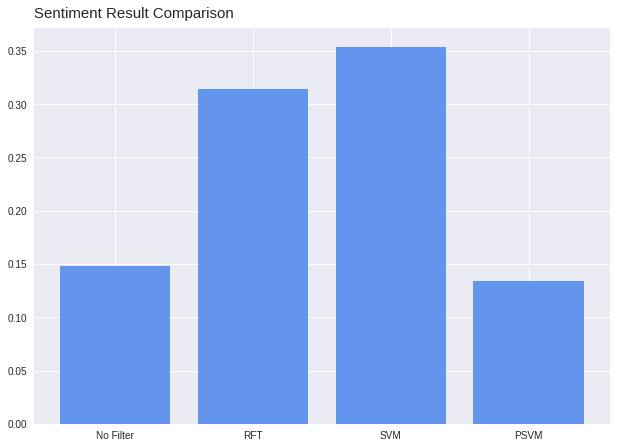

In [50]:
# Create sentiment comparison graph
import matplotlib.pyplot as plt
plt.style.use('seaborn')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
filters = ['No Filter', 'RFT', 'SVM','PSVM']
value_v = [unfilt_sent,filt_sent,svm_sent,svm2_sent]
ax.bar(filters,value_v,color='cornflowerblue')
plt.title('Sentiment Result Comparison', fontsize=15, horizontalalignment='left',x=0, pad=10)
plt.show()